In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_img(path, gray=False):
    """
    OpenCVを用いて画像を読み込む関数．
    
    Parameters
    ----------
    path : str
        画像へのパス
    gray : True or False
        グレー画像として読み込むかの設定
    
    returns
    ----------
    img : object
        読み込んだ画像
    """
    if gray:
        img = cv2.imread(path, 0)  # IMREAD_GRAYSCALE
    else:
        img = cv2.imread(path, 1)  # IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 色空間の変換
    
    return img

In [124]:
def make_mask(img):
    """
    色抽出を行って，マスク画像を生成する関数．
    
    Parameters
    ----------
    img : object
        対象とする画像(OpenCVで読み込んだBGRカラー画像)
    
    returns
    ----------
    mask : object
        対象のマスク画像
    """
    
    # RGBでの色抽出
    shrimp_lower = np.array([120, 41, 1])    # 下限141 63
    shrimp_upper = np.array([255, 188, 87])  # 上限
    shrimp_mask = cv2.inRange(img, shrimp_lower, shrimp_upper)  # マスク画像
    shrimp = cv2.bitwise_and(img, img, mask=shrimp_mask)        # クリッピング画像
    
    # 色抽出した結果から二値化マスク画像に変換
    gray = cv2.cvtColor(shrimp, cv2.COLOR_RGB2GRAY)
    ret, mask_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    
    # ノイズ除去
    # 収縮の後に膨張(opening)させて背景領域中の白点の除去
    kernel = np.ones((12, 12), np.uint8)  # やや広めに取る
    opening = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel)

    # 膨張の後に収縮(closing)させて，前景領域中の黒点の除去
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    mask = closing
    return mask

In [7]:
# 保存先ディレクトリがなければ作成
save_dir = './datasets/train/images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
dataset_path = './datasets/shrimp/tray_train/'
images_path = glob.glob(os.path.join(dataset_path, '*.JPG'))

## 大津の閾値でのマスク画像の作成

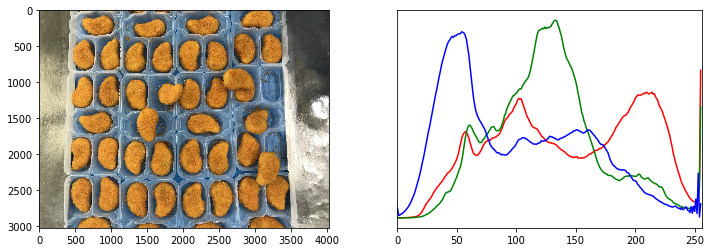

In [91]:
plt.figure(figsize=(12, 4))

# 元画像の読み込みと表示
img = load_img(images_path[0])  # トレー部分は[100:, 600:3300, :]
plt.subplot(121); plt.imshow(img)

# RGBのカラーヒストグラムの表示
plt.subplot(122)
color = ('r', 'g', 'b')
for i, c in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=c)
    plt.xlim([0, 256])
    plt.yticks([])

plt.show()

([], <a list of 0 Text yticklabel objects>)

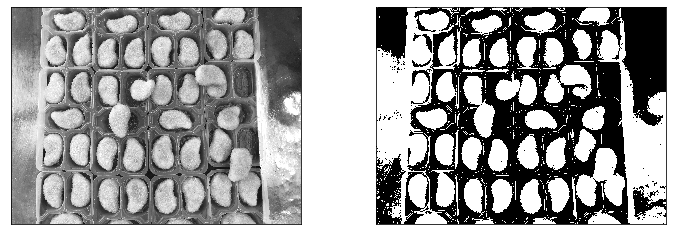

In [93]:
plt.figure(figsize=(12, 4))

img = load_img(images_path[0])
img = img[:, :, 0]  # R成分のみ抽出

# 大津の閾値処理
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(121); plt.imshow(img, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.subplot(122); plt.imshow(thresh, cmap='gray'); plt.xticks([]); plt.yticks([])

## 特定の色のみを抽出してマスクを作成

([], <a list of 0 Text yticklabel objects>)

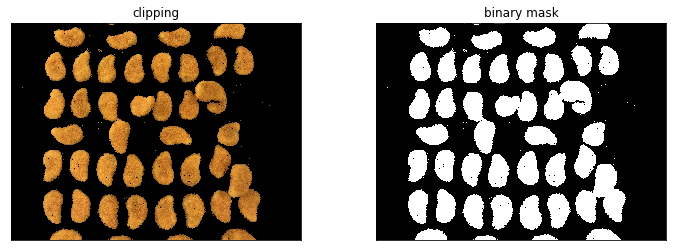

In [100]:
plt.figure(figsize=(12, 4))

img = load_img(images_path[0])

# RGBでの色抽出
shrimp_lower = np.array([120, 41, 1])    # 下限141 63
shrimp_upper = np.array([255, 188, 87])  # 上限
shrimp_mask = cv2.inRange(img, shrimp_lower, shrimp_upper)  # マスク画像
shrimp = cv2.bitwise_and(img, img, mask=shrimp_mask)        # クリッピング画像
plt.subplot(121); plt.title('clipping')
plt.imshow(shrimp)
plt.xticks([])
plt.yticks([])

# 色抽出した結果から二値化マスク画像に変換
gray = cv2.cvtColor(shrimp, cv2.COLOR_RGB2GRAY)
ret, mask_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
plt.subplot(122); plt.title('binary mask')
plt.imshow(mask_bin, cmap='gray')
plt.xticks([])
plt.yticks([])

### ノイズ除去

([], <a list of 0 Text yticklabel objects>)

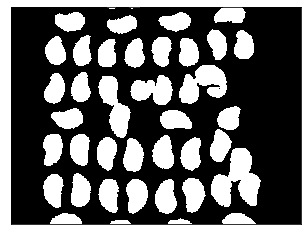

In [110]:
# 収縮の後に膨張(opening)させて背景領域中の白点の除去
kernel = np.ones((12, 12), np.uint8)  # やや広めに取る
opening = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel)
# plt.imshow(opening, cmap='gray')

# 膨張の後に収縮(closing)させて，前景領域中の黒点の除去
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')
plt.xticks([])
plt.yticks([])

## Watershedを試してみる

In [12]:
images_path[0]

'./datasets/shrimp/tray_train\\IMG_0720.JPG'

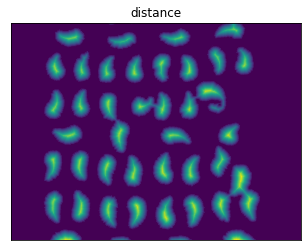

In [119]:
# 距離変換を行う(オブジェクトと背景の距離を出す)
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
plt.imshow(dist_transform)
plt.title('distance')
plt.xticks([])
plt.yticks([])
plt.show()

閾値(距離変換で得られた値の最大値×0.5): 77.36279296875


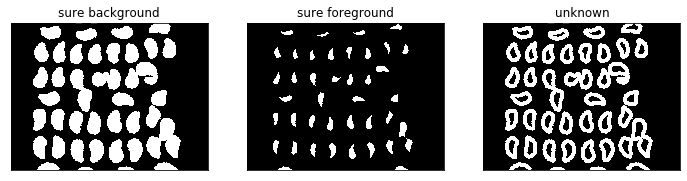

In [120]:
# 膨張させて，明確な背景(sure background)情報を得る
kernel = np.ones((5, 5), np.uint8)
sure_bg = cv2.dilate(closing, kernel, iterations=1)

# 明確な前景(sure foreground)を出す
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
print('閾値(距離変換で得られた値の最大値×0.5):', ret)

# 背景でも前景でもないunknownな境界部分を抽出
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(sure_bg, cmap='gray'); plt.title('sure background')
plt.xticks([]); plt.yticks([])
plt.subplot(132); plt.imshow(sure_fg, cmap='gray'); plt.title('sure foreground')
plt.xticks([]); plt.yticks([])
plt.subplot(133); plt.imshow(unknown, cmap='gray'); plt.title('unknown')
plt.xticks([]); plt.yticks([])
plt.show()

before watershed : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int32), array([11341874,    16486,    17904,    14614,     9732,    14728,
          18118,    18744,    18329,    20111,    18787,    13835,
          15353,    27146,    16942,    18845,    21387,    18946,
          16311,    14286,    25737,    18520,    20496,    19285,
          19086,    23689,    19895,    27496,    22491,    24108,
          24510,    64437,    22007,    24312,    26341,    28433,
          23444,    28603,    28553,    14494,    14353], dtype=int64))
add unknown : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int32), array([3128154, 8213720,   16486,   17904,   14614,    9732,   14728,
         1811

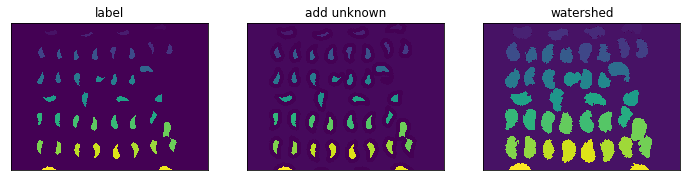

In [121]:
plt.figure(figsize=(12, 4))

# foregroundの1オブジェクトごとにラベリング
ret, markers = cv2.connectedComponents(sure_fg)
plt.subplot(131); plt.imshow(markers); plt.title('label')
plt.xticks([]); plt.yticks([])

# markersのデータの中身，0:背景 1以降:物体
print('before watershed : \n', np.unique(markers, return_counts=True))

# 0をunknown境界として用いるため，1を足して，1:背景 2以降:物体とする
markers += 1
markers[unknown == 255] = 0
plt.subplot(132); plt.imshow(markers); plt.title('add unknown')
plt.xticks([]); plt.yticks([])

# 0:unknown 1:背景 2以降:物体
print('add unknown : \n', np.unique(markers, return_counts=True))

# 各情報からwatershedを実行
markers = cv2.watershed(img, markers)
plt.subplot(133); plt.imshow(markers); plt.title('watershed')
plt.xticks([]); plt.yticks([])

# watershed実行後は-1:境界 1:背景 2以降:物体
print('after watershed : \n', np.unique(markers, return_counts=True))

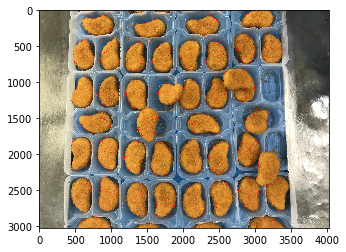

In [122]:
# 境界の領域を青で塗る
img[markers == -1] = [255, 0, 0]
plt.imshow(img)

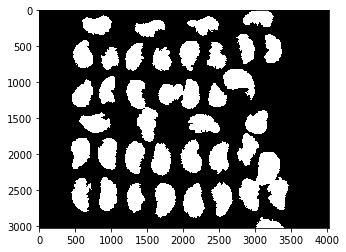

In [123]:
# マスク画像を生成
height, width, _ = img.shape
mask = np.zeros((height, width))  # 原型を作成

for i in range(2, 41):            # 1は背景のため除外
    mask[markers == i] = 255      # 領域部分を白に
mask[markers == i] = 255          # -1も境界のため白に

plt.imshow(mask, cmap='gray')

## マスク画像の保存

In [133]:
save_dir = './datasets/train/masks/'
images_dir = './datasets/train/images/'
images_path = glob.glob(os.path.join(images_dir, '*.JPG'))
for path in images_path:
    img = load_img(path)
    mask = make_mask(img)
    
    file_name = path[-12:-4] + '.png'  # ファイル名(.JPGより前の部分)
    save_path = os.path.join(save_dir, file_name)
    cv2.imwrite(save_path, mask)

'IMG_0720png'

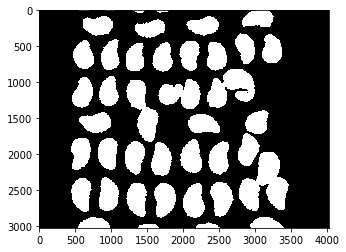

In [132]:
file_name = path[-12:-4] + 'png'  # ファイル名(.JPGより前の部分)
save_path = os.path.join(save_dir, file_name)
plt.imshow(mask, cmap='gray')
file_name